In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf



In [2]:
# anulo el uso de la GPU por falta de memoria
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #'-1' for no GPU

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

# tf.enable_eager_execution()
tf.VERSION

GPU found


'1.13.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2

from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.models import load_model
import keras.backend as K

from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train


DATA_PATH = "data"

Using TensorFlow backend.


In [4]:
import os
print(os.listdir("data"))

['results_df_20190710232755.pkl', 'results_test_df_20190710232755.pkl', 'processed_train_images', 'results_df_20190711090031.pkl', 'results_test_models_df_20190711111832.pkl', 'results_test_df_20190712001832.pkl', 'train.csv', 'results_df.pkl', 'train_images', 'test.csv', 'test_images', 'results_test_df_20190711090031.pkl', 'processed_test_images', 'results_test_df.pkl', 'sample_submission.csv', 'results_df_20190712001832.pkl', 'results_test_model2_df_20190711111855.pkl', 'results_test_model2_df_20190712083607.pkl']


In [5]:
df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_test = pd.read_csv(DATA_PATH + '/test.csv')

# The Model
## inspired in real life

help obtained from
https://machinelearningmastery.com/keras-functional-api-deep-learning/


In [6]:
# Aquí transcribimos las imágenes a un fichero tipo TFRECORD de tamaño
width = 400
height = 500

size = (width,height)


In [7]:
# ---------------------
# OPTION 1
# ---------------------
''' '''

input_layer = tf.keras.Input(shape=(width,height,1))
print('input_layer: ', input_layer.shape)

layer1 = tf.keras.layers.Conv2D(200, kernel_size=(5, 5), activation='relu')(input_layer)
print('layer: ', layer1.shape)

layer2 = tf.keras.layers.MaxPooling2D(pool_size=(5, 5))(layer1)
print('layer: ', layer2.shape)

layer3 = tf.keras.layers.Conv2D(200, kernel_size=(2, 2), activation='relu')(layer2)
print('layer: ', layer3.shape)

layer4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer3)
print('layer: ', layer4.shape)

layer5 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer4)
print('layer: ', layer5.shape)

layer6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer5)
print('layer: ', layer6.shape)

layer7 = tf.keras.layers.Flatten()(layer6)
print('layer: ', layer7.shape)

layer8 = tf.keras.layers.Dense(10*NUM_CLASSES, activation='relu')(layer7)
print('layer: ', layer8.shape)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(layer8)
print('output_layer: ', output_layer.shape)

model = tf.keras.Model(inputs = [input_layer], outputs = [output_layer])




input_layer:  (?, 400, 500, 1)
Instructions for updating:
Colocations handled automatically by placer.
layer:  (?, 396, 496, 200)
layer:  (?, 79, 99, 200)
layer:  (?, 78, 98, 200)
layer:  (?, 39, 49, 200)
layer:  (?, 38, 48, 100)
layer:  (?, 19, 24, 100)
layer:  (?, 45600)
layer:  (?, 50)
output_layer:  (?, 5)


In [8]:
def diagnoses_from_list(row):
    n = 0.0
    diagnoses = 0.0
    for i in row[0]:
        diagnoses += i*n
        n += 1.0
    return int(diagnoses)


def crop_image1(img,tol=8):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


In [15]:
def crop_image1(img,tol=8):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


In [16]:
def enhance(image, clip_limit=3, Crop = True, size=(400,500)):
    # convert image to LAB color model
    
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert iamge from LAB color model back to RGB color model
    image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Auto Crop image
    cropped_image = crop_image1(image_gray, 8)
    
    # resize image
    resized_image = cv2.resize(cropped_image, size)
    # Include Ben Graham preprocessing (-4 value)
    if Crop:
        final_image=cv2.addWeighted ( resized_image,4, 
                                     cv2.GaussianBlur( resized_image , (0,0) , IMG_SIZE/10) ,-4 ,128)
        return final_image
    else:
        return resized_image

In [17]:
model_file = ["/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0030.h5",
              "/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0050.h5",
              "/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0090.h5",
              "/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0150.h5"]


In [18]:
import tqdm

def test_model():
    results_train = {}
    for i in tqdm.tqdm(df_train.iterrows()):
        path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i[1][0]}.png"
        image = cv2.imread(path)
        enhanced_image = enhance(image,2, True, size)
        # img = image.img_to_array(enhanced_image)
        img = enhanced_image.reshape((1,width, height, 1))/255
        results_train[i[0]] = [i[1][0], i[1][1], model.predict(img)]
    return results_train


In [19]:
results_test_models_df = pd.DataFrame()
i = 0
for m in model_file:
    print(m)
    model.load_weights(m)
    res = test_model()
    res_df = pd.DataFrame.from_dict(res, 
                                    orient='index', 
                                    columns=['img_id', 'diagnosis', f'prediction_{i}'])
    res_df[f'predicted_{i}'] = res_df.apply( 
        lambda x: diagnoses_from_list(x[f'prediction_{i}']), axis=1)
    res_df[f'predict_ok_{i}'] = res_df.apply( 
        lambda x: 1 if x[f'predicted_{i}']==x['diagnosis'] else 0, axis=1)
    res_df[f'predict_error_{i}'] = res_df.apply(
        lambda x: 1 if x[f'predicted_{i}']!=x['diagnosis'] else 0, axis=1)
    if i == 0:
        results_test_models_df = pd.concat([results_test_models_df, 
                                        res_df['diagnosis'],
                                        res_df['img_id'],
                                        res_df[f'predicted_{i}'],
                                        res_df[f'predict_ok_{i}'],
                                       res_df[f'predict_error_{i}']], axis=1, sort=False)
    else:
        results_test_models_df = pd.concat([results_test_models_df, 
                                        res_df[f'predicted_{i}'],
                                        res_df[f'predict_ok_{i}'],
                                       res_df[f'predict_error_{i}']], axis=1, sort=False)        
    i += 1


0it [00:00, ?it/s]

/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0030.h5


3662it [11:42,  4.94it/s]
0it [00:00, ?it/s]

/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0050.h5


3662it [11:38,  4.97it/s]
0it [00:00, ?it/s]

/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0090.h5


3662it [11:37,  4.98it/s]
0it [00:00, ?it/s]

/mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0150.h5


3662it [11:38,  5.00it/s]


In [20]:
results_test_models_df.groupby('diagnosis').sum()

,predicted_0,predict_ok_0,predict_error_0,predicted_1,predict_ok_1,predict_error_1,predicted_2,predict_ok_2,predict_error_2,predicted_3,predict_ok_3,predict_error_3
diagnosis,,,,,,,,,,,,
0,408,1586,219,338,1597,208,388,1594,211,294,1625,180
1,368,355,15,365,362,8,354,351,19,353,353,17
2,1825,508,491,1639,436,563,1699,483,516,1661,489,510
3,547,161,32,530,144,49,524,138,55,496,110,83
4,894,11,284,894,15,280,901,18,277,923,41,254


In [21]:
results_test_models_df.head(10)

,diagnosis,img_id,predicted_0,predict_ok_0,predict_error_0,predicted_1,predict_ok_1,predict_error_1,predicted_2,predict_ok_2,predict_error_2,predicted_3,predict_ok_3,predict_error_3
0,2,000c1434d8d7,2,1,0,2,1,0,2,1,0,2,1,0
1,4,001639a390f0,3,0,1,3,0,1,3,0,1,3,0,1
2,1,0024cdab0c1e,1,1,0,1,1,0,1,1,0,1,1,0
3,0,002c21358ce6,0,1,0,0,1,0,0,1,0,0,1,0
4,0,005b95c28852,0,1,0,0,1,0,0,1,0,0,1,0
5,4,0083ee8054ee,3,0,1,3,0,1,3,0,1,3,0,1
6,0,0097f532ac9f,2,0,1,0,1,0,3,0,1,2,0,1
7,2,00a8624548a9,2,1,0,2,1,0,2,1,0,2,1,0
8,2,00b74780d31d,1,0,1,2,1,0,2,1,0,2,1,0
9,1,00cb6555d108,1,1,0,1,1,0,1,1,0,1,1,0


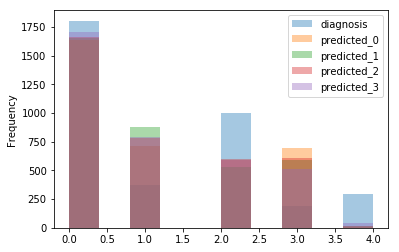

In [23]:
results_test_models_df[['diagnosis',
                       'predicted_0',
                       'predicted_1',
                       'predicted_2',
                       'predicted_3']].plot.hist(alpha=0.4)


In [ ]:
import datetime
lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_test_models_df.to_pickle(f"{DATA_PATH}/results_test_model2_df_{lt}.pkl")
